In [1]:
import math         # sine, cosine, sqrt, etc.
import numpy as np  # so we can work with matrices

import matplotlib
import matplotlib.pyplot as plt # plotting

In [2]:
# [x1,y1], ... the (x,y) position of node 1, 2, 3...
nodes = np.array([
    [0,0],
    [1,0],
    [1,1]
])
# a list of all the nodes
node_numbers = np.array([*range(len(nodes))])

In [3]:
# element n is connected at nodes i and j
# element n: [node i, node j, Young's Modulus, Cross Sectional Area] ... note: we'll calculate L later
elements = np.array([
    [1,2,10,1],
    [2,3,5,1],
    [1,3,20*math.sqrt(2), 1]
])

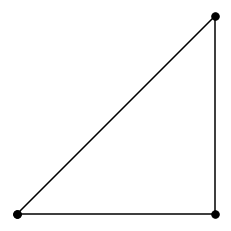

In [4]:
# set axes aspect ratio = 1
# turn off the axis
plt.axes().set_aspect('equal') 
plt.axis('off') 

# plot the nodes
plt.plot([nodes[0], nodes[1]], 'k.',markersize=15)
# plot the elements
# loop through the list of elements, grab the x position and y position of each node associated with that element
# the line: 'elements[i,0]-1' is necessary because python starts counting at 0, not 1 (like MATLAB)
for i in range(len(elements)):
    plt.plot(np.array([
    nodes[int(elements[i,0]-1),0], nodes[int(elements[i,1]-1),0]]),
         np.array([nodes[int(elements[i,0]-1),1], nodes[int(elements[i,1]-1),1]]),
         'k-')
plt.show()

In [5]:
# dirichlet boundary conditions
# [node, DoF (x=1, y=2), value]
bc = np.array([
    [1,1,0],
    [1,2,0],
    [2,2,0]
])

In [6]:
# neumann boundary conditions - e.g. forces
# [node, DoF (x=1,y=2), magnitude of force]
forces = np.array([
    [3,1,2],
    [3,2,1]
])

In [7]:
def XY(nodes, elements, i):
    return np.array([
        nodes[int(elements[i,0]-1)],
        nodes[int(elements[i,1]-1)]
    ])

In [8]:
# elemental stiffness matrix in global coordinates
def Kel(XY, E, A):
    x1, y1, x2, y2 = XY[0,0], XY[0,1], XY[1,0], XY[1,1]
    
    L = math.sqrt((x2-x1)**2 + (y2-y1)**2)
    c = (x2-x1)/L
    s = (y2-y1)/L
    
    Kel = E*A/L*np.array([
        [c**2, c*s, -c**2, -c*s],
        [c*s, s**2, -c*s, -s**2],
        [-c**2, -c*s, c**2, c*s],
        [-c*s, -s**2, c*s, s**2]
    ])
    
    return Kel  

In [9]:
# What nodes are not connected to the ith element?
# list_of_all_nodes+1... the +1 is to align python numbering (starts at 0) with our numbering (starts at 1)
def missingNodes(list_of_all_nodes, list_of_element_nodes): 
    return (list(set(list_of_all_nodes+1) - set(list_of_element_nodes+1))) 

In [10]:
# augment the elemental stiffness matrix by adding rows & columns of zeroes at the missing nodes
def Kaug(Kel, element):
    
    missing = missingNodes(node_numbers,elements[element,:2]-1)
    
    Kaug1 = np.insert(Kel, missing, 0, axis=0)
    Kaug2 = np.insert(Kaug1, missing, 0, axis=0)
    Kaug3 = np.insert(Kaug2, missing, 0, axis=1)
    Kaug  = np.insert(Kaug3, missing, 0, axis=1)
    return Kaug

In [11]:
# initializing the vectors F, u, and the matrix K
F = u = np.zeros(2*len(nodes))
K = np.zeros([2*len(nodes), 2*len(nodes)])

In [12]:
def MasterStiffness(nodes, elements, K):
# Calculate the Master Stiffness matrix:
# 1. Get the x & y coordinates of each node connected to element i
# 2. Calculate the stiffness matrix for element i
# 3. Augment the elemental stiffness matrix to the size of K
# 4. Add it to K, loop over the remaining elements
    for i in range(len(elements)):
        nodesXY = XY(nodes, elements, i)
        Keli  = Kel(nodesXY, elements[i,2], elements[i,3])
        Kaugi = Kaug(Keli, i)
        K = np.add(K, Kaugi)    
    return K

In [13]:
K = MasterStiffness(nodes, elements, K)

In [14]:
# initialize vectors for the specified displacements and forces. these will be [1 x DoF]
u_specified=[]
F_specified=[0]*2*len(nodes)

# 
for i in range(len(bc)):
    u_specified.append(2*(bc[i,0]-1)+bc[i,1]-1)
for i in range(len(forces)):    
    F_specified[(2*(forces[i,0]-1)+forces[i,1])-1]=forces[i,2]
    
u_unknown = np.delete(u,u_specified)
K_reduced = np.delete(K,u_specified,0)
K_reduced = np.delete(K_reduced,u_specified,1)
#F_unknown = np.delete(F,u_specified)
F_specified = np.delete(F_specified,u_specified)

In [15]:
F_specified

array([0, 2, 1])

In [16]:
K_reduced

array([[10.,  0.,  0.],
       [ 0., 10., 10.],
       [ 0., 10., 15.]])

In [17]:
# np.linalg.lstsq does the matrix left division. 
# it returns the residuals, rank, etc. of the calculation, so we just grab the list, which is element [0]
u_unknown = np.linalg.lstsq(K_reduced,F_specified, rcond=None)[0]

In [18]:
u_unknown

array([ 0. ,  0.4, -0.2])

In [19]:
# create a list of all the displacement degrees of freedom (DoF)
u_DoF=[]
for i in range(len(u)):
    u_DoF.append(i)

# get the index locations of the free degrees of freedom (DoF)    
u_free = (list(set(u_DoF) - set(u_specified)))    

# put the free (formerly unknown) displacements into the displacement vector u
np.put(u,u_free,u_unknown)

In [20]:
u

array([ 0. ,  0. ,  0. ,  0. ,  0.4, -0.2])

In [36]:
F=np.dot(K,u)